In [8]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more

import numpy as np
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [9]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel

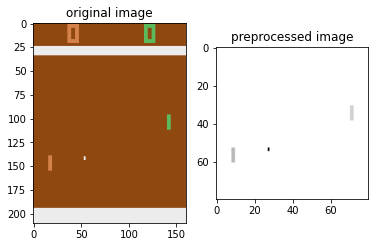

In [10]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()


# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        # 80x80*2 to 40*40*4 to 20*20*8
        # outputsize = (inputsize - kernel_size + 2*padding)/stride +1 
        # (round up if not an integer)

        # output = 20x20 here
        self.conv1 = nn.Conv2d(2, 4, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=2, stride=2)
        self.size=20*20*8
        
        # 1 fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # flatten the tensor
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))

# use your own policy!
# policy=Policy().to(device)
policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [12]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    discount = discount**np.arange(len(rewards))
    rewards  = np.asarray(rewards)*discount[:,np.newaxis]
    
    #Convert rewards to future rewards )i.e. cumulative sum of rewards from Si to Sn)
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    actions  = torch.tensor(actions, dtype=torch.int8, device=device)

        
    #Noise reduction using normalizing rewards across trajectories
    mean = np.mean(rewards_future, axis=1)
    std  = np.std(rewards_future, axis=1) +1e-10
    rewards_norm = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_norm, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)
    
    ratio = new_probs/old_probs 
    clipped_surrogate = torch.min(ratio*rewards, torch.clamp(ratio, 1-epsilon, 1+epsilon)*rewards)
    # include a regularization term
    # this steers new_policy towards 0.5
    # prevents policy to become exactly 0 or 1 helps exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(beta*entropy + clipped_surrogate)

# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [13]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 500

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

Episode: 20, score: -14.500000
[-10. -17. -16. -15. -12. -14. -16. -16.]


Episode: 40, score: -14.000000
[-11. -14. -16. -17. -16. -12. -15. -11.]


Episode: 60, score: -12.500000
[-16. -12. -10. -16.  -5. -16. -16.  -9.]


Episode: 80, score: -14.125000
[-14. -15. -13. -17. -14. -13. -13. -14.]


Episode: 100, score: -13.125000
[-12. -13. -14. -13.  -8. -13. -15. -17.]


Episode: 120, score: -13.750000
[-15. -15. -13. -13. -16. -16. -15.  -7.]


Episode: 140, score: -13.375000
[-12. -13. -10. -12. -16. -14. -16. -14.]


Episode: 160, score: -12.625000
[-12. -12. -13. -14. -12.  -9. -13. -16.]


Episode: 180, score: -10.625000
[-10. -14. -14.  -3.  -3. -13. -14. -14.]


Episode: 200, score: -11.250000
[ -7. -14. -13. -12.  -9. -10. -12. -13.]


Episode: 220, score: -9.000000
[ -9. -10.  -9.  -5.  -8. -10. -11. -10.]


Episode: 240, score: -8.750000
[ -9. -11.  -6. -11. -10.  -8.  -3. -12.]


Episode: 260, score: -8.875000
[-10. -10. -12.  -9.  -7.  -8.  -9.  -6.]


Episode: 280, score: -8.750000
[ -4.  -9. -12.  -4.  -8. -12. -10. -11.]


Episode: 300, score: -5.250000
[-4. -8. -5. -4. -5. -7. -4. -5.]


Episode: 320, score: -5.750000
[-4. -9. -3. -4. -8. -6. -5. -7.]


Episode: 340, score: -3.375000
[-4.  1. -3. -7. -3. -6. -1. -4.]


Episode: 360, score: -0.750000
[-1.  0.  0. -2. -1. -1. -1.  0.]


Episode: 380, score: 0.000000
[ 0.  0.  1.  1. -3.  2. -2.  1.]


Episode: 400, score: -0.750000
[-1. -3. -2. -1.  0.  1. -1.  1.]


Episode: 420, score: 0.000000
[ 0.  1.  1.  2.  0. -2. -2.  0.]


Episode: 440, score: -0.250000
[ 0.  1. -2.  0.  0. -1. -2.  2.]


Episode: 460, score: 0.625000
[ 1.  1. -1.  1.  0.  0.  2.  1.]


Episode: 480, score: 1.500000
[0. 2. 0. 2. 2. 4. 0. 2.]


Episode: 500, score: 0.750000
[ 1.  1.  1.  0.  2.  1.  1. -1.]


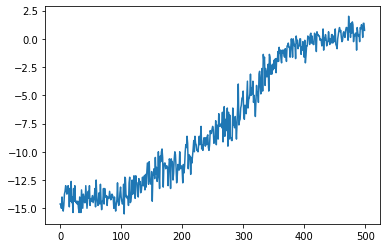

In [14]:
plt.plot(mean_rewards)